<a href="https://colab.research.google.com/github/GitTanmai/regression_ml/blob/main/Resume_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
#importing all required libraries

import PyPDF2
import os
from os import listdir
from os.path import isfile, join
from io import StringIO
import pandas as pd
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()
from spacy.matcher import PhraseMatcher

In [44]:
#pip install PyPDF2

In [45]:
#Function to read resumes from the folder one by one
mypath='/content/' #enter your path here where you saved the resumes
onlyfiles = [os.path.join(mypath, f) for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]

In [46]:
def pdfextract(file):
    fileReader = PyPDF2.PdfFileReader(open(file,'rb'))
    countpage = fileReader.getNumPages()
    count = 0
    text = []
    while count < countpage:    
        pageObj = fileReader.getPage(count)
        count +=1
        t = pageObj.extractText()
        #print ('hhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh',t)
        text.append(t)
    return text

#function to read resume ends

In [47]:
#function that does phrase matching and builds a candidate profile
def create_profile(file):
    text = pdfextract(file) 
    text = str(text)
    text = text.replace("\\n", "")
    text = text.lower()
    #below is the csv where we have all the keywords, you can customize your own
    keyword_dict = pd.read_csv('/content/Table3.csv')
    stats_words = [nlp(text) for text in keyword_dict['Statistics'].dropna(axis = 0)]
    NLP_words = [nlp(text) for text in keyword_dict['NLP'].dropna(axis = 0)]
    ML_words = [nlp(text) for text in keyword_dict['Machine learning'].dropna(axis = 0)]
    DL_words = [nlp(text) for text in keyword_dict['Deep Learning'].dropna(axis = 0)]
    R_words = [nlp(text) for text in keyword_dict['R language'].dropna(axis = 0)]
    python_words = [nlp(text) for text in keyword_dict['Python language'].dropna(axis = 0)]
    Data_Engineering_words = [nlp(text) for text in keyword_dict['Data Engineering'].dropna(axis = 0)]

    matcher = PhraseMatcher(nlp.vocab)
    matcher.add('Stats', None, *stats_words)
    matcher.add('NLP', None, *NLP_words)
    matcher.add('ML', None, *ML_words)
    matcher.add('DL', None, *DL_words)
    matcher.add('R', None, *R_words)
    matcher.add('Python', None, *python_words)
    matcher.add('DE', None, *Data_Engineering_words)
    doc = nlp(text)
    
    d = []  
    matches = matcher(doc)
  
    for match_id, start, end in matches:
        rule_id = nlp.vocab.strings[match_id]  # get the unicode ID, i.e. 'COLOR'
        span = doc[start : end]  # get the matched slice of the doc
        d.append((rule_id, span.text))      
    keywords = "\n".join(f'{i[0]} {i[1]} ({j})' for i,j in Counter(d).items())
    
    ## convertimg string of keywords to dataframe
    df = pd.read_csv(StringIO(keywords),names = ['Keywords_List'])
    df1 = pd.DataFrame(df.Keywords_List.str.split(' ',1).tolist(),columns = ['Subject','Keyword'])
    df2 = pd.DataFrame(df1.Keyword.str.split('(',1).tolist(),columns = ['Keyword', 'Count'])
    df3 = pd.concat([df1['Subject'],df2['Keyword'], df2['Count']], axis =1) 
    df3['Count'] = df3['Count'].apply(lambda x: x.rstrip(")"))
    
    base = os.path.basename(file)
    filename = os.path.splitext(base)[0]
       
    name = filename.split('_')
    name2 = name[0]
    name2 = name2.lower()
    ## converting str to dataframe
    name3 = pd.read_csv(StringIO(name2),names = ['Candidate Name'])
    
    dataf = pd.concat([name3['Candidate Name'], df3['Subject'], df3['Keyword'], df3['Count']], axis = 1)
    dataf['Candidate Name'].fillna(dataf['Candidate Name'].iloc[0], inplace = True)

    return(dataf)
        
#function ends

# New Section

In [48]:
#code to execute/call the above functions

final_database=pd.DataFrame()

for i in range(0, len(onlyfiles)):
    file = onlyfiles[i]
    if 'pdf' in file:
      print('fffffffffffffffffffffffffffffffffffffffffffff',file)
      dat = create_profile(file)
      final_database = final_database.append(dat)
      
      #print(final_database)

fffffffffffffffffffffffffffffffffffffffffffff /content/Ravinder.pdf
fffffffffffffffffffffffffffffffffffffffffffff /content/Uphaar.pdf


In [49]:
final_database

,Candidate Name,Subject,Keyword,Count
0,ravinder,Python,python,10
1,ravinder,NLP,natural language processing,2
2,ravinder,Python,sklearn,5
3,ravinder,Python,pandas,5
4,ravinder,NLP,nltk,5
5,ravinder,Stats,probability,1
6,ravinder,DL,tensorflow,3
7,ravinder,DE,aws,4
8,ravinder,DE,ec2,4
9,ravinder,NLP,nlp,1


In [50]:
#code to count words under each category and visulaize it through Matplotlib

final_database2 = final_database['Keyword'].groupby([final_database['Candidate Name'], final_database['Subject']]).count().unstack()

final_database2.reset_index(inplace = True)
final_database2.fillna(0,inplace=True)
new_data = final_database2.iloc[:,1:]
new_data.index = final_database2['Candidate Name']
new_data

Subject,DE,DL,ML,NLP,Python,Stats
Candidate Name,,,,,,
ravinder,3.0,3.0,0.0,3.0,6.0,1.0
uphaar,1.0,0.0,3.0,4.0,6.0,1.0


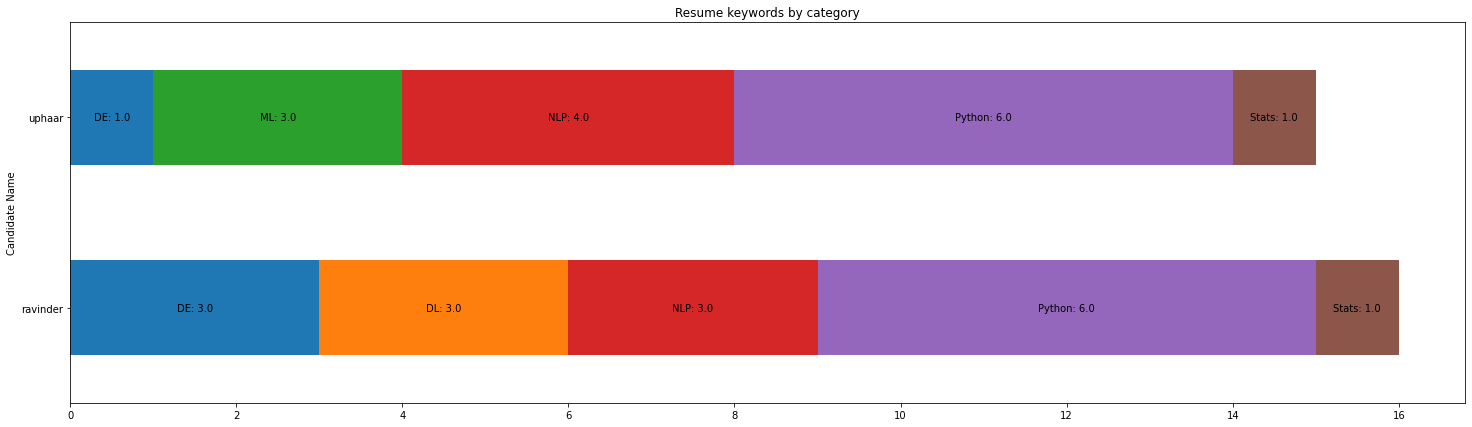

In [51]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
ax = new_data.plot.barh(title="Resume keywords by category", legend=False, figsize=(25,7), stacked=True)
labels = []
for j in new_data.columns:
    for i in new_data.index:
        label = str(j)+": " + str(new_data.loc[i][j])
        labels.append(label)
patches = ax.patches
for label, rect in zip(labels, patches):
    width = rect.get_width()
    if width > 0:
        x = rect.get_x()
        y = rect.get_y()
        height = rect.get_height()
        ax.text(x + width/2., y + height/2., label, ha='center', va='center')
plt.show()

In [103]:
#Generate df with weightage and technology


df = pd.read_csv('/content/Table3.csv')
#ndf=df.iloc[:, 0:2].append(df.iloc[:, 2:4], ignore_index = True)
col1=list(df.iloc[:,0])+ list(df.iloc[:,2]) + list(df.iloc[:,4])+ list(df.iloc[:,6])+list(df.iloc[:,8])+ list(df.iloc[:,10])+list(df.iloc[:,12])
col2=list(df.iloc[:,1])+ list(df.iloc[:,3]) + list(df.iloc[:,5])+ list(df.iloc[:,7])+list(df.iloc[:,9])+ list(df.iloc[:,11])+list(df.iloc[:,13])
tabledf=pd.DataFrame(list(zip(col1, col2)),columns =['Keyword', 'Weightage'])
tabledf.dropna(axis=0, how='all',inplace=True)
tabledf.head(5)


,Keyword,Weightage
0,statisticalmodels,10.0
1,statisticalmodeling,10.0
2,probability,10.0
3,normal distribution,10.0
4,poisson distribution,10.0


In [104]:
tabledf[tabledf['Keyword']=='natural language processing']
#tabledf.info

,Keyword,Weightage
101,natural language processing,10.0


In [81]:
final_database.head(2)

,Candidate Name,Subject,Keyword,Count
0,ravinder,Python,python,10
1,ravinder,NLP,natural language processing,2


In [107]:
df_inner = pd.merge(final_database, tabledf, on='Keyword', how='right')

df_inner

,Candidate Name,Subject,Keyword,Count,Weightage
0,NaN,NaN,statisticalmodels,NaN,10.0
1,NaN,NaN,statisticalmodeling,NaN,10.0
2,NaN,NaN,probability,NaN,10.0
3,NaN,NaN,normal distribution,NaN,10.0
4,NaN,NaN,poisson distribution,NaN,10.0
...,...,...,...,...,...
87,NaN,NaN,aws lambda,NaN,5.0
88,NaN,NaN,aws emr,NaN,5.0
89,NaN,NaN,hive,NaN,5.0
90,NaN,NaN,hadoop,NaN,5.0


In [109]:
d=final_database.join(tabledf, on='Keyword', how='left',sort=False)
d

ValueError: ignored